In [ ]:
import pandas as pd 
from datasets import Dataset
import random
import numpy as np

In [ ]:
dataframes = []
train_ratio = 0.8
def preprocess_data(df_list):
    for df in df_list:
        comments_df = df[["CONTENT","CLASS"]]
        dataframes.append(comments_df) 
    df = pd.concat(dataframes, axis=0)
    df_final = df.sample(frac=1, random_state=42)
    num_samples = len(df_final)
    num_train = int(train_ratio * num_samples)
    train_data = df_final[:num_train]
    test_data = df_final[num_train:]
    return [{"sentence":train_data["CONTENT"],
                "label":train_data["CLASS"]},
           {"sentence":test_data["CONTENT"],
               "label":test_data["CLASS"]}]

In [ ]:
data1 = pd.read_csv("Youtube01-Psy.csv")
data2 = pd.read_csv("Youtube02-KatyPerry.csv")
data3 = pd.read_csv("Youtube03-LMFAO.csv")
#data4 = pd.read_csv("Youtube04-Eminem.csv")
#data5 = pd.read_csv("Youtube05-Shakira.csv")

In [ ]:
df_list = preprocess_data([data1,data2])

In [ ]:
train_dict = df_list[0]
test_dict = df_list[1]

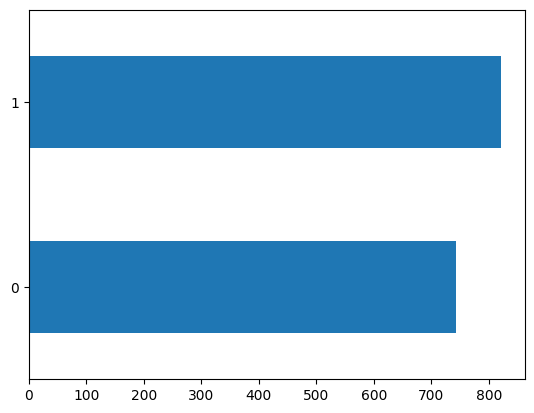

In [ ]:
import matplotlib.pyplot as plt
train_dict["label"].value_counts(ascending=True).plot.barh();
# Seems like a balanced dataset will proceed furthur

In [ ]:
import pandas as pd 
train_df = pd.DataFrame.from_dict(train_dict)

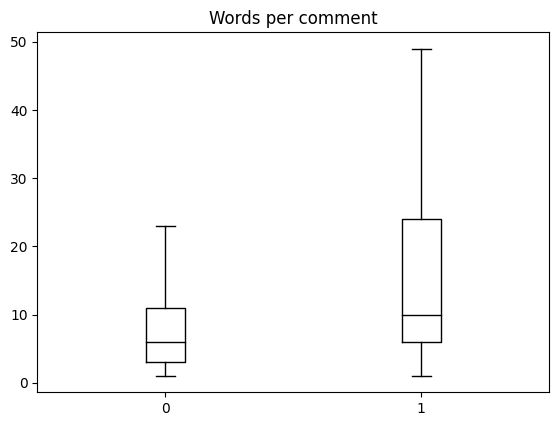

In [ ]:
# Check the maximum lenght and average lenght of the comments for the distill-bert transformer
train_df['Words per comment'] = train_df['sentence'].str.split().apply(len)
train_df.boxplot("Words per comment", by='label', grid= False, showfliers= False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
train_data = Dataset.from_dict(train_dict)
test_data = Dataset.from_dict(test_dict)

In [ ]:
def tokenize_text(dataset):
    return tokenizer(dataset["sentence"], truncation=True, padding=True)

train_dataset = train_data.map(tokenize_text, batched=True)
test_dataset = test_data.map(tokenize_text, batched=True)

In [ ]:
print(train_dataset.column_names)

['sentence', 'label', 'input_ids', 'attention_mask']


In [ ]:

from transformers import AutoModelForSequenceClassification
import torch
num_labels = 2
#Train model using CUDA cores is present 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels).to(device)
         )

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 4
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-spam"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=1,
                                  per_device_eval_batch_size=1,
                                  weight_decay=0.01,
                                  gradient_accumulation_steps=4,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [ ]:
import os 
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '4'

In [ ]:
import os 
from transformers import Trainer


trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  tokenizer=tokenizer)
trainer.train();

In [ ]:
#Save finetuned model with model weights 
trainer.save_model("spam_model")

In [4]:
#Load the saved model using the transformers pipeline
from transformers import pipeline
classifier = pipeline("text-classification", model="../spam_model_pt")
classifier("Checkout this video")

[{'label': 'LABEL_1', 'score': 0.8595367670059204}]